In [1]:
import itertools
import pandas as pd
from scipy import stats
import statsmodels.api as sm
%pylab inline

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv(
    "./WAG_C_M.csv", 
    sep=';', 
    index_col=['month'], 
    parse_dates=['month'], 
    dayfirst=True
)

# 1. Визуальный анализ ряда

Для начала посмотрим на датасет:

In [4]:
df.head(6)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
1993-06-01,47.4


Рассмотрим график

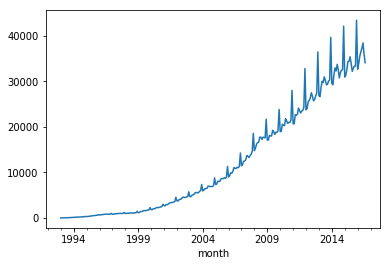

In [5]:
df.WAG_C_M.plot()

Согласно графику, ряд имеет сильную трендовую составляющую, и имеется сезонная составляющая.   
Также видно что имеется растущий размах колебаний, который можно трактовать как проявление гетерокседаксичности. 

Согласно расссмотренным особенностям графика, ряд является нестационарным.

<Figure size 1080x720 with 0 Axes>

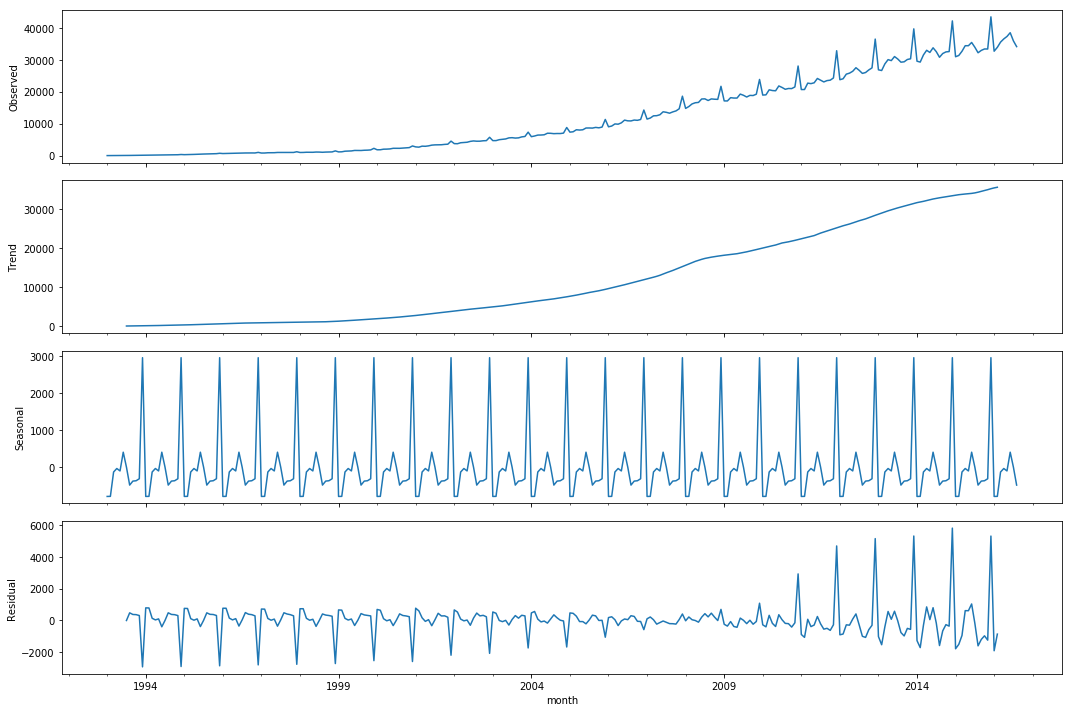

In [6]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(df.WAG_C_M).plot()

# 2. Стабилизация дисперсии (при необходимости)

Проверим необходимость стабилизации дисперсии и выберем оптимальное (приблизительно) значение ляимбда.

In [7]:
min_pvalue = 1.
min_lmd = None

def criteria(lmd):
    return sm.tsa.adfuller(stats.boxcox(df.WAG_C_M, lmbda=lmd))[1]

for lmd in pd.np.arange(0., 3., 0.01):
    if min_lmd is None:
        min_lmd = lmd
        min_pvalue = criteria(lmd)
    else:
        pvalue = criteria(lmd)
        if pvalue < min_pvalue:
            min_lmd = lmd
            min_pvalue = pvalue

print "min lambda: ", min_lmd
print "min p-value", min_pvalue

min lambda:  0.0
min p-value 0.03401037411699181


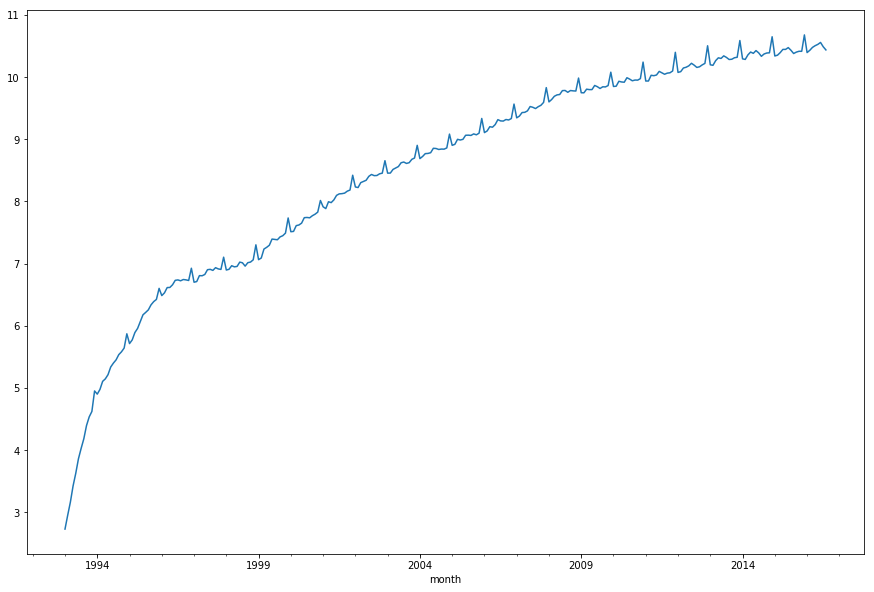

In [8]:
df["boxcox"] = stats.boxcox(df.WAG_C_M, lmbda=0.)
df["boxcox"].plot()

Подобранное значение лябда не равно 1, что говорит о необходимости преобразования. 

# 3. Выбор порядка дифференцирования

Проверим ряд на стационарность с помощью критерия Дики-Фуллера

In [9]:
sm.tsa.adfuller(df.boxcox)

(-3.00956915070421,
 0.03401037411699181,
 14,
 269,
 {'1%': -3.4548957220044336,
  '10%': -2.572527778361272,
  '5%': -2.8723451788613157},
 -1217.2355475245004)

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. 

Однако, при простмотре графиков STL заметно наличие трендовой и сезонной компоненты. Поэтому проведем сезонное, а затем линейное дифференцирование.

## 3.1 Проверка продиффернцированного ряда с d=1 и D=1

Проведем циклическое диффернцирование с периодом 12 и обычное диференцирование.

In [10]:
box_T12D1d0 = df.boxcox - df.boxcox.shift(12)
box_T12D1d1 = (box_T12D1d0 - box_T12D1d0.shift(1))[13:]

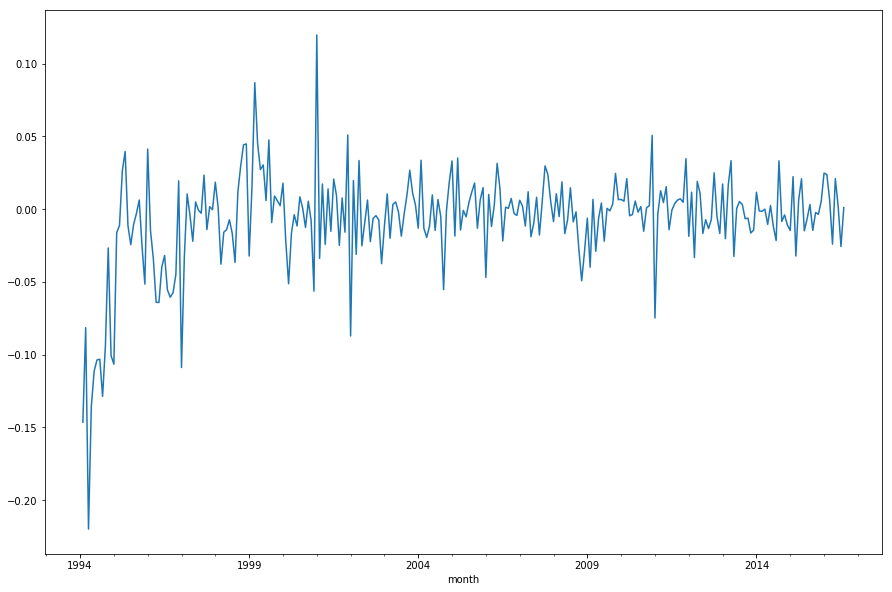

In [11]:
box_T12D1d1.plot()

Проведем аугментированный DF-тест

In [12]:
sm.tsa.adfuller(box_T12D1d1)

(-3.407349893525082,
 0.010710851546579366,
 16,
 254,
 {'1%': -3.456360306409983,
  '10%': -2.572870232500465,
  '5%': -2.8729872043802356},
 -1200.951735659067)

<Figure size 1080x720 with 0 Axes>

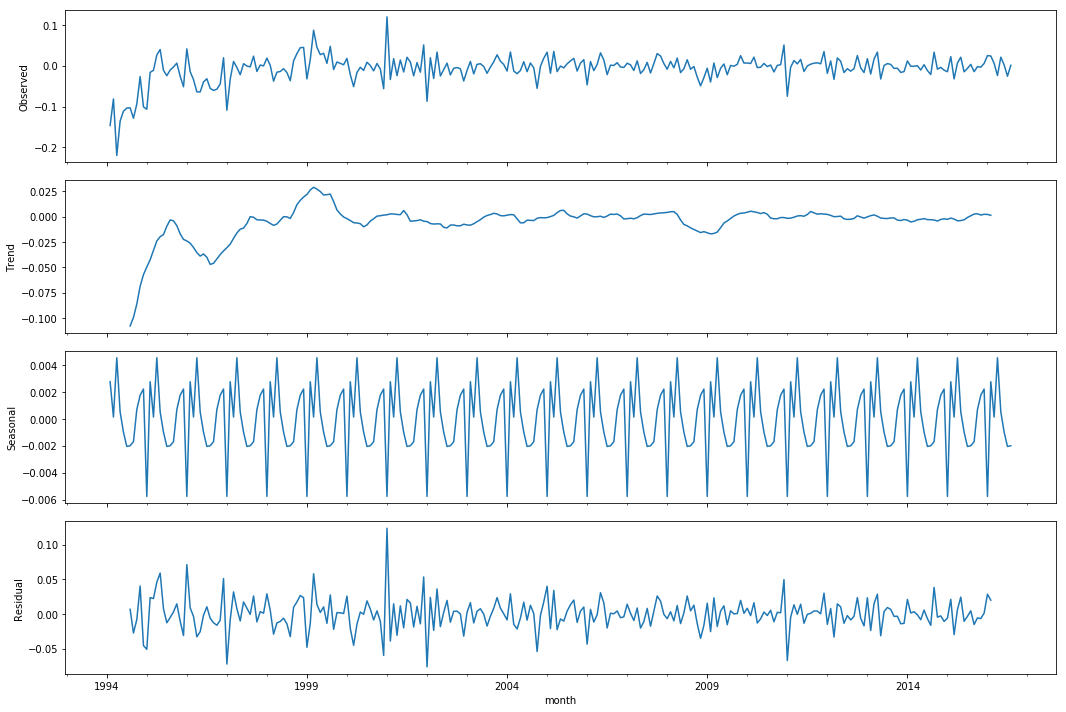

In [13]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(box_T12D1d1).plot()

После подбора параметров дифференцирования на графике исчезла сезонность и почти исчез тренд. Ряд визуально выглядик достаточно стационарным.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. 

## 3.2 Проверка продиффернцированного ряда с d=1 и D=2

In [14]:
box_T12D2d1 = (box_T12D1d1 - box_T12D1d1.shift(12))[12:]

Проведем DF-тест:

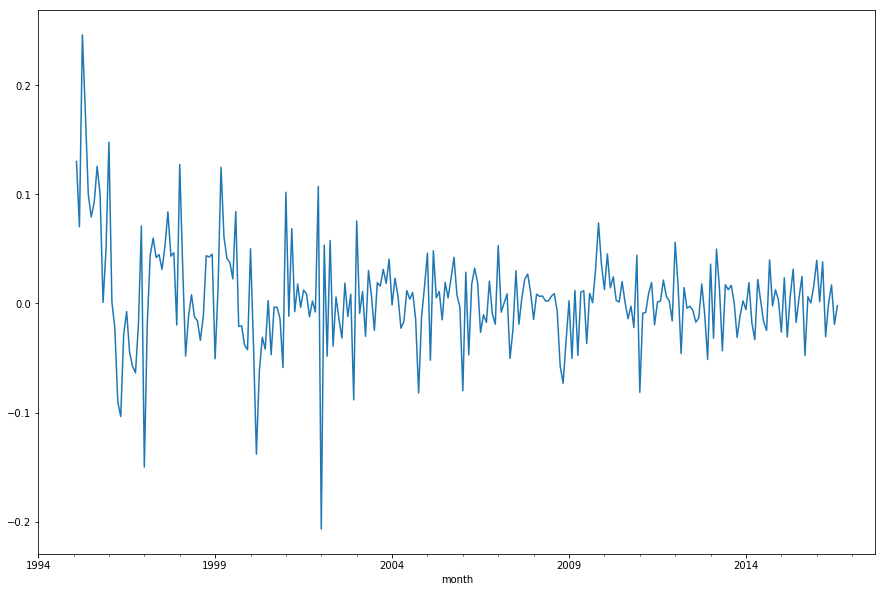

In [15]:
box_T12D2d1.plot()

In [16]:
sm.tsa.adfuller(box_T12D2d1)

(-4.282159913852129,
 0.00047689495989306467,
 16,
 242,
 {'1%': -3.457664132155201,
  '10%': -2.5731749894132916,
  '5%': -2.8735585105960224},
 -1002.6713389294669)

<Figure size 1080x720 with 0 Axes>

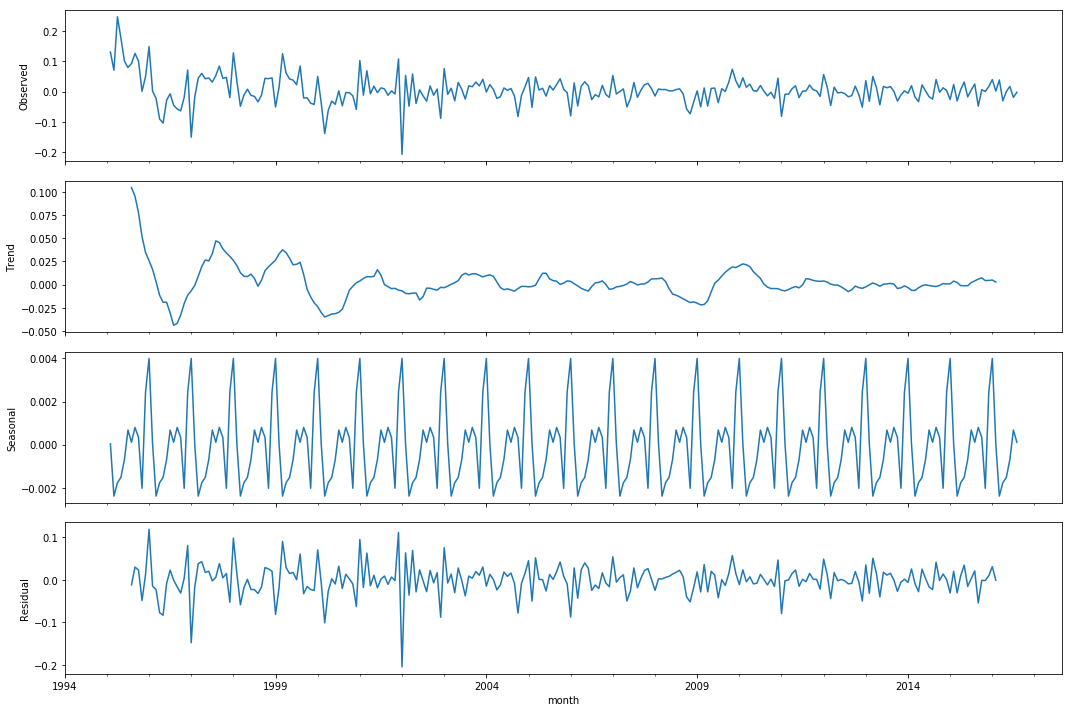

In [17]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(box_T12D2d1).plot()

Визуально виден тренд на STL-декомпозиуии, сезонная составляющая на графике остатков кажется менее значимой по сравнени с предыдущими примерами.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. Также достигаемый уровень значимости заметно уменьшился.

## 3.3 Проверка продиффернцированного ряда с d=2 и D=1

In [18]:
box_T12D1d2 = (box_T12D1d1 - box_T12D1d1.shift(1))[1:]

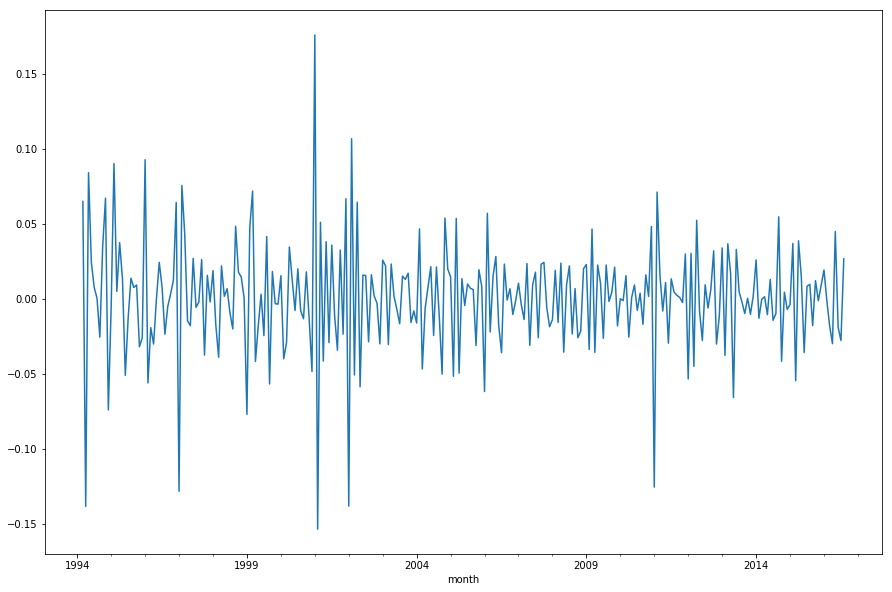

In [19]:
box_T12D1d2.plot()

In [20]:
sm.tsa.adfuller(box_T12D1d2)

(-8.988698961989256,
 6.9865211502484135e-15,
 16,
 253,
 {'1%': -3.4564641849494113,
  '10%': -2.572894516864816,
  '5%': -2.873032730098417},
 -1188.3554117067813)

<Figure size 1080x720 with 0 Axes>

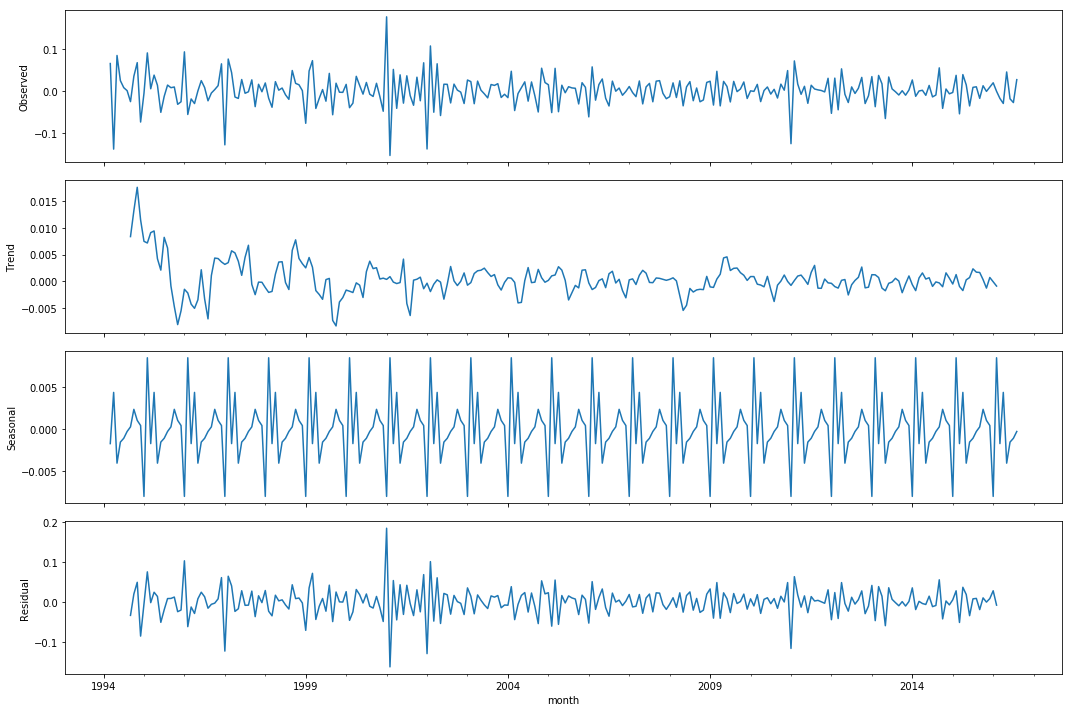

In [21]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(box_T12D1d2).plot()

Визуально виден тренд на STL-декомпозиуии, но в этот раз он меньше.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. 

## 3.4 Проверка продиффернцированного ряда с d=2 и D=2

In [22]:
box_T12D2d2 = (box_T12D2d1 - box_T12D2d1.shift(1))[1:]

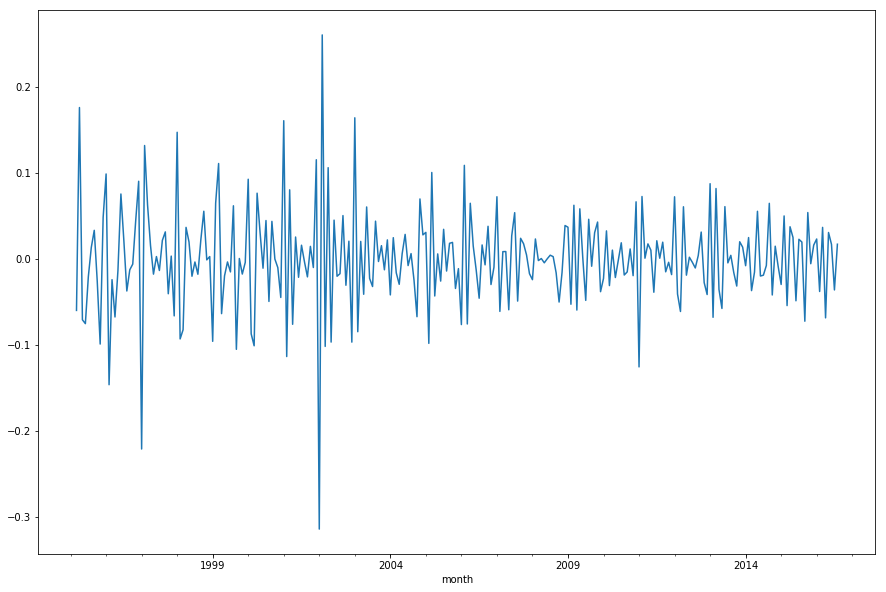

In [23]:
box_T12D2d2.plot()

In [24]:
sm.tsa.adfuller(box_T12D2d2)

(-9.986893172691879,
 2.0441967026179032e-17,
 16,
 241,
 {'1%': -3.4577787098622674,
  '10%': -2.573201765981991,
  '5%': -2.873608704758507},
 -987.0589543764422)

<Figure size 1080x720 with 0 Axes>

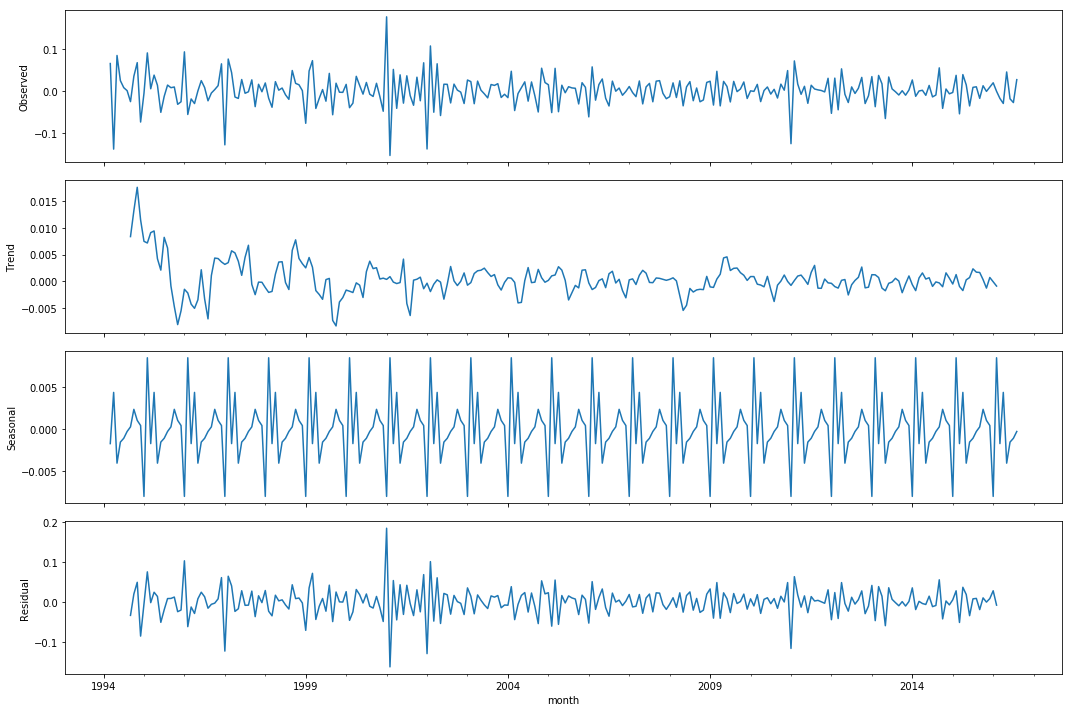

In [25]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(box_T12D1d2).plot()

Визуально тренд еще остается и все еще видны признаки сезонности.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. 

На самом деле я пробовал эти варианты на всем пайплайне ноутбука и этот вариант показал себя лучше всех.

## 3.3 Проверка продиффернцированного ряда с d=3 и D=2

In [26]:
box_T12D2d3 = (box_T12D2d2 - box_T12D2d2.shift(1))[1:]

In [27]:
sm.tsa.adfuller(box_T12D2d3)

(-7.092997751678039,
 4.3611708755837444e-10,
 16,
 240,
 {'1%': -3.4578942529658563,
  '10%': -2.573228767361111,
  '5%': -2.8736593200231484},
 -911.9497054411781)

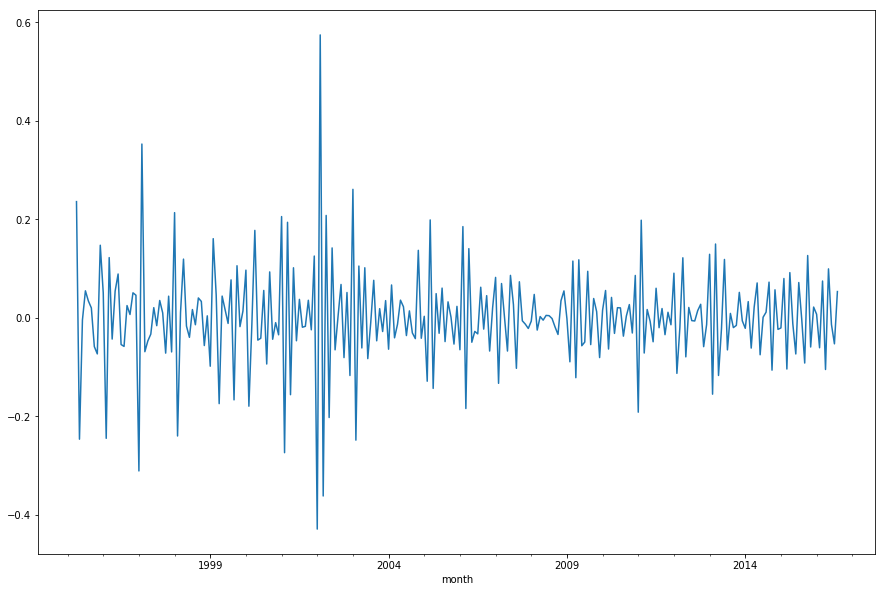

In [28]:
box_T12D2d3.plot()

<Figure size 1080x720 with 0 Axes>

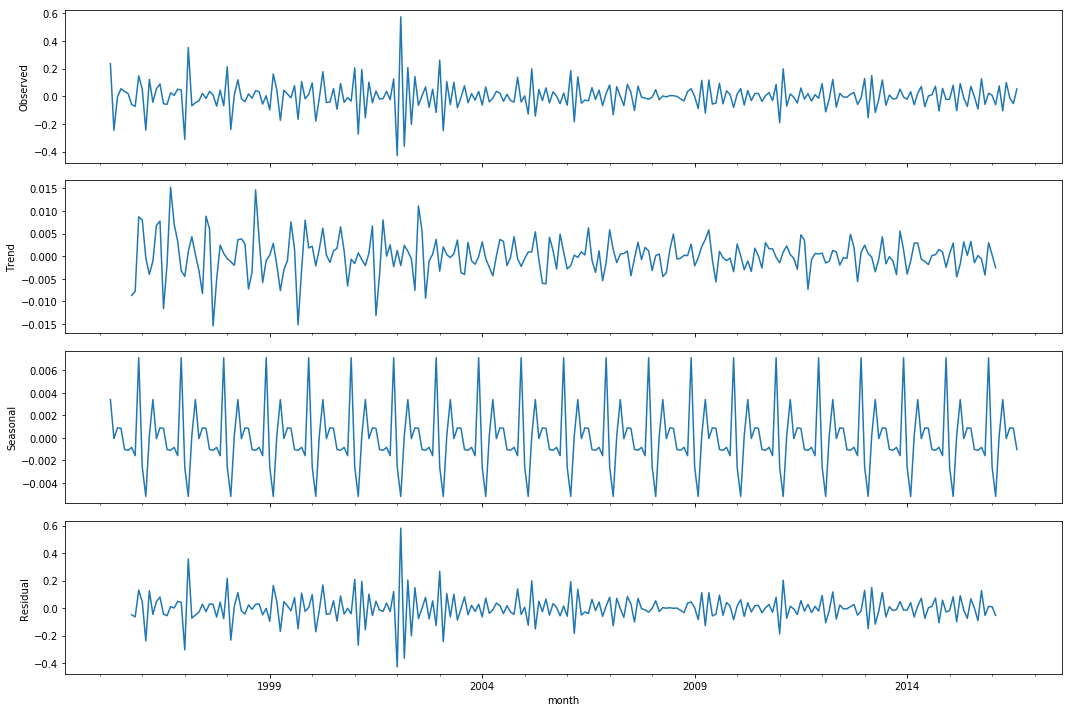

In [29]:
plt.figure(figsize(15, 10))
_ = sm.tsa.seasonal_decompose(box_T12D2d3).plot()

Третее дифференцирование помогло избавиться от тренда.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. Но достигаемый уровень значимости увеличелся в несколько раз.

Также при дальнейшей работе с этим вариантом тест Ljung-Box  стал идентифицировать наличие автокоррелированности остатков. А также был сильный разброс при низком смещении, что является признаком переобученности

Поэтому останвимся на параметрах D=2 и d=2.

# 4. Выбор начальных приближений для p, q, P, Q

Построим автокорреляционную функцию

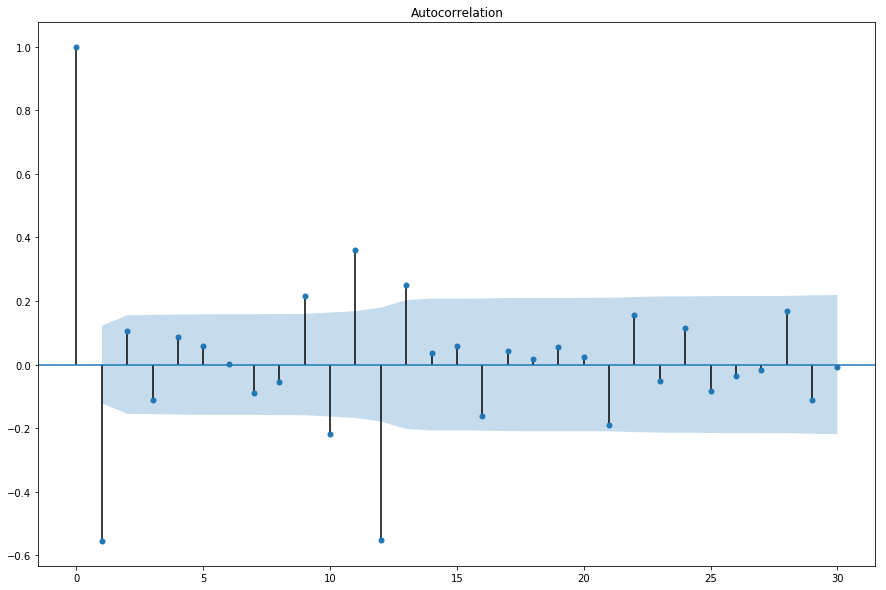

In [36]:
_ = sm.graphics.tsa.plot_acf(box_T12D2d2.values.squeeze(), lags=30)

Согласно автокорреляционной функции у ряда имеется сезонность, которая остается значимой на первом лаге, поэтому Q будет равна 1.
В качестве q выберем лаг 13, так как аналогичная точка предыдущего периода не значима.

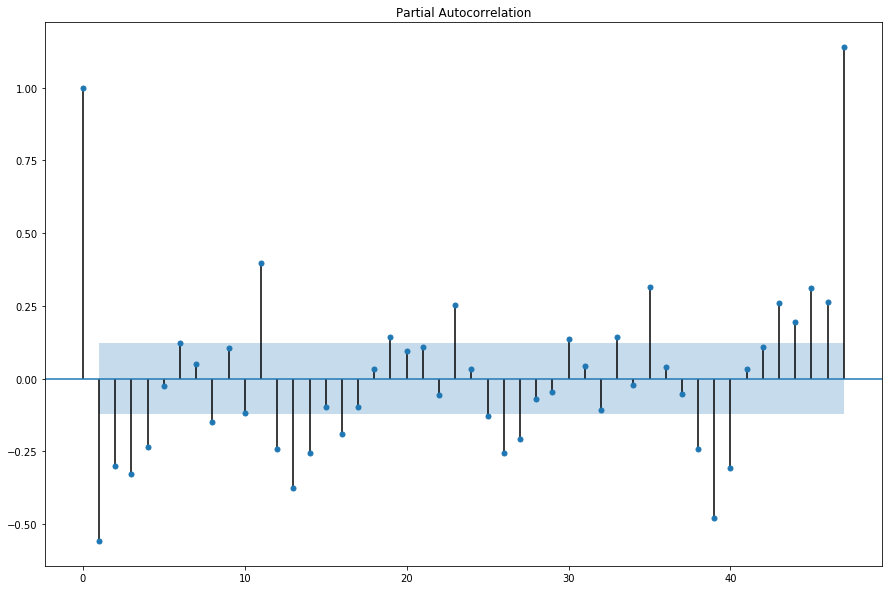

In [40]:
_ = sm.graphics.tsa.plot_pacf(box_T12D2d2.values.squeeze(), lags=47)

На графике видно, что начиная с 4-го сезонного лага нарушается цикличность (период стал меньше), поэтому P возьмем равным 3. То что происходит дальше больше похоже на переобучение.
В качестве начального значения p возьмем 10. Дальнейшие значимые точки по моему мнению относятся либо к сезонности, либо к переобучению.

# 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [58]:
ps = range(0, 11)
d = 2
qs = range(0, 10)
Ps = range(0, 5)
D = 2
Qs = range(0, 2)

init_p = 10
init_q = 9
init_P = 4
init_Q = 1

In [59]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

1100

In [53]:
def init_pPqQ(p,q,P,Q, d, D):
    param = (p, q, P, Q)
    aic = None
    try:
        model = sm.tsa.statespace.SARIMAX(
            df.boxcox, 
            order=(
                param[0], 
                d, 
                param[1]
            ), 
            seasonal_order=(
                param[2], 
                D, 
                param[3], 
                12
            )
        ).fit(disp=-1)
        aic = model.aic
        return aic
    except ValueError:
        print('wrong parameters:', param)
        return None

In [54]:
%%time
results = []
best_aic = float("inf")
best_param = None
warnings.filterwarnings('ignore')


init_aic = init_pPqQ(init_p, init_q, init_P, init_Q, 3, 1)

if init_aic is not None:
    best_aic = init_aic
    best_param = (init_p, init_q, init_P, init_Q)

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            df.boxcox, 
            order=(
                param[0], 
                d, 
                param[1]
            ), 
            seasonal_order=(
                param[2], 
                D, 
                param[3], 
                12
            )
        ).fit(disp=-1)
#         print('correct parameters:', param)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (10, 12, 1, 1))
('wrong parameters:', (0, 7, 0, 0))
('wrong parameters:', (0, 7, 0, 1))
('wrong parameters:', (0, 7, 1, 0))
('wrong parameters:', (0, 7, 1, 1))
('wrong parameters:', (0, 8, 0, 0))
('wrong parameters:', (0, 8, 0, 1))
('wrong parameters:', (0, 8, 1, 0))
('wrong parameters:', (0, 8, 1, 1))
('wrong parameters:', (0, 10, 0, 0))
('wrong parameters:', (0, 10, 0, 1))
('wrong parameters:', (0, 10, 1, 0))
('wrong parameters:', (0, 10, 1, 1))
('wrong parameters:', (1, 5, 0, 0))
('wrong parameters:', (1, 5, 0, 1))
('wrong parameters:', (1, 5, 1, 0))
('wrong parameters:', (1, 5, 1, 1))


KeyboardInterrupt: 

Рассмотрим кандидатов:

In [ ]:
print(results)

In [ ]:
print("В качестве победителя выберем модель с параметрами p=%s, q=%s, P=%s, Q=%s."%best_param)

# 6. Анализ остатков построенной модели

Рассмотим лучшую модель

In [ ]:
best_model.summary()

Критерий Льюнга-Бокса вывел достигаемый уровень значимоси меньше 5%, значит гипотезу об автокоррелированности остатков можно отвергнуть.

In [ ]:
stats.ttest_1samp?

In [41]:
stats.ttest_1samp?

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Выбрав уровень знаимости 0.05, можно утверждать следующее:
Остатки стационарны согласно критерию Дикки-Фуллера, достигаемый уровень значемости пренебрежительно мал.
Остатки смещены согласно критерию Стьюдента, согласно тексту задания при построении прогноза нам потребеттся вычесть константу, в качестве константы возьмем среднее арифметическое от остатков. 

В примере временной ряд также не прошел тест Стьюдента, обсуждение данной проблемы можно посмотреть по созданному мною топику: https://www.coursera.org/learn/data-analysis-applications/discussions/weeks/1/threads/-9pXKxHUEemI2Arzs2jnSA

Также можно заключить, что данные неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Посмотрим, насколько хорошо модель описывает данные:

In [ ]:
df['model'] = invboxcox(best_model.fittedvalues, 0)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Визуально, модель хорошо описывает временной ряд, при этом не потребовалось смещения смоделлированных значени на константу. 

Теперь проведем сравнение с учетом смещения смоделированного ряда. 

Будем смещать на следующую величину:

In [ ]:
best_model.resid.mean()

Рассмотрим график:

In [ ]:
df['model'] = invboxcox(best_model.fittedvalues, 0) - best_model.resid.mean()
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

После коррекции по устранению смещенности, модель также хорошо описывает временной ряд.

# 7. Прогнозирование с помощью финальной модели.

In [ ]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=284+35), 0) - best_model.resid.mean()

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Прогноз выглядит достаточно адекватным:
 - прогноз воспроизел сезонность ряда
 - Прогноз не выглядит смещенным относительно ряда.
 - Прогноз уловил разворот тренда, что на первый взгляд выглядит удивительным, но объясняетя наличием отрицательных коэффициентов в авторегрессии и в сезонной авторегрессии. А также, если рассмотреть график разносте (расположенный ниже), то можно увидеть замедление кскорения исходного ряда (то есть скорость графика разностей) и даже начало разворота в двух последних сезонах.

In [ ]:
(df.WAG_C_M - df.WAG_C_M.shift(1))[1:].plot()